# CNN Multiclass Classification

In this exercise, we will build a classifier model that is able to distinguish ALL the classes in the CIFAR100 dataset. We will follow these steps:

1. Explore the example data
2. Build a small convolutional neural network to solve our classification problem
3. Evaluate training and validation accuracy
4. Transfer learning
5. Visualizing kernels


## 1. Data Exploration and Preparation

We'll start by downloading the CIFAR-100 dataset.

This is a link to the docs:
https://keras.io/api/datasets/cifar100/ 

Be sure to set your Runtime environment to include a GPU/TPU, as it will speed up the training considerably.

### Uploading zipped datafile into a folder local to Colab

In [ ]:
from keras.datasets import cifar100

(X, y), (_, _) = cifar100.load_data()
print('X shape: ', X.shape)
print('y shape:', y.shape)

169001437/169001437 [==============================] - 2s 0us/step
X shape:  (50000, 32, 32, 3)
y shape: (50000, 1)


###  Import needed functions and libraries

In [ ]:
# For matrix operations
import numpy as np

# Data visualizaton.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random as rn
 
# Configure some defaults.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D 
import tensorflow as tf

### Data Preparation & Exploration

Let's take a look at a few of these images.

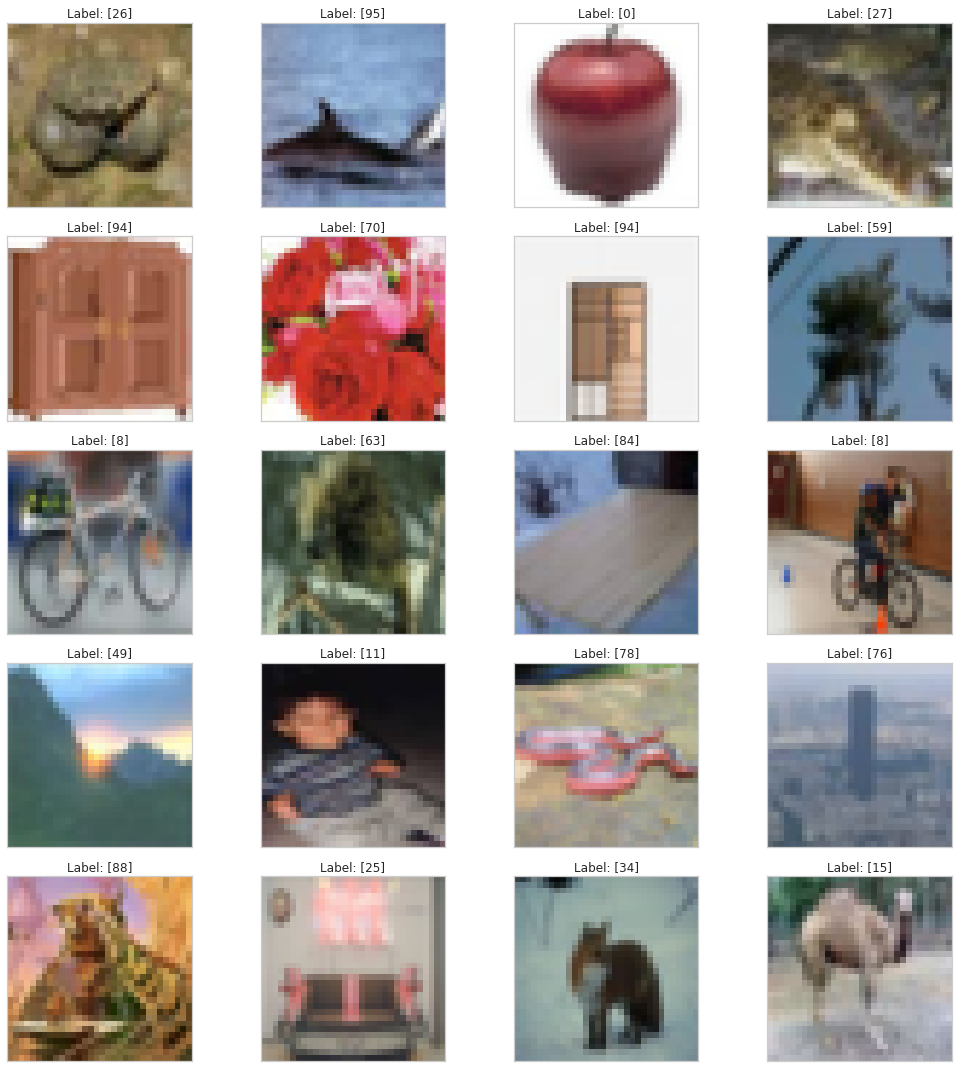

In [ ]:
fig, ax = plt.subplots(5, 4)
fig.set_size_inches(15, 15)

for i in range(5):
    for j in range(4):
        l=rn.randint(0, len(y))
        ax[i, j].imshow(X[l], cmap='gray')
        ax[i, j].set_title('Label: ' + str(y[l]))
        # Hide grid lines
        ax[i, j].grid(False)
        # Hide axes ticks
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
plt.tight_layout()

### One hot encode the labels, and normalize the data

In [ ]:
# One-hot encode those integer values.
y = to_categorical(y, 100)

# Normalize X in the interval [0, 1]
X = X / 255.

print('X shape: ', X.shape)
print('y shape:', y.shape)

X shape:  (50000, 32, 32, 3)
y shape: (50000, 100)


Let's set some random seeds to make this more reproducible. 

In [ ]:
def setseeds():
  np.random.seed(137)
  rn.seed(137)
  tf.random.set_seed(137)

setseeds()

## 2. Define our CNN architecture, using Keras

In [ ]:
# This is where we define the architecture of our deep neural network.

model = Sequential()

model.add(Conv2D(filters = 16,      
                 kernel_size = (3, 3), 
                 padding = 'Same',
                 activation = 'relu', 
                 input_shape = (32, 32, 3)))

model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32,      
                 kernel_size = (3, 3), 
                 padding = 'Same',
                 activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(200, activation = 'relu'))  

model.add(Dense(100, activation = "softmax"))


In [ ]:
# A batch is the size of each training chunk. We're implementing batch gradient descent, which is in between
# stochastic gradient descent and full gradient descent.
batchsize = 200
# Each epoch goes through the entire training set once
epochs = 30  

Next we compile the model we've defined, and specify our loss function. We'll be using categorical cross-entropy, which is usual for multi-class classification.

In [ ]:
model.compile(optimizer = Adagrad(lr = 0.001),
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


Let's look at a summary of our deep neural network model.

In [ ]:
model.summary()

# num_param_i = num_kernels * (1 + dim_k * dim_k * depth_of_input)
# 448 = 16 * (1 + 3 * 3 * 3)
# 64 = 16 (num_channels) * 4 (gamma, beta, running mean, and running std)
# 4640 = 32 * (1 + 3 * 3 * 16)
# 409800 = (1 + 2048) * 200
# 20100 = (1 + 200) * 100

#conv2d = 16, (3*3), same, (32, 32, 3)
#maxpool2d = (2*2)
#batchnormalization
#conv2d = 32, (3*3), same
#maxpool2d = (2*2)
#flatten
#dense 200, relu
#dense softmax 100

# for one feature: (3*3 * (num_of_input_channels) + 1) = 3*3*3 + 1 = 28
# for all of feature (kernels) =  16 * 28
# 32 - 3 + 1 = 30 --> 30 * 30
# zero-padding = (34 * 34) --> 34 - 3 + 1 = 32

# 32 * (3*3 * 16 + 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                        

### Train our model

It will take a minute to train.

In [ ]:
setseeds()

history = model.fit(X, y,
                    epochs = epochs, 
                    batch_size = batchsize,
                    validation_split = 0.1,
                    verbose = 1)

Epoch 1/30
225/225 [==============================] - 10s 8ms/step - loss: 4.6294 - accuracy: 0.0151 - val_loss: 4.5732 - val_accuracy: 0.0190
Epoch 2/30
225/225 [==============================] - 1s 6ms/step - loss: 4.4944 - accuracy: 0.0340 - val_loss: 4.4781 - val_accuracy: 0.0378
Epoch 3/30
225/225 [==============================] - 1s 6ms/step - loss: 4.3859 - accuracy: 0.0485 - val_loss: 4.3509 - val_accuracy: 0.0490
Epoch 4/30
225/225 [==============================] - 1s 6ms/step - loss: 4.2709 - accuracy: 0.0621 - val_loss: 4.2374 - val_accuracy: 0.0646
Epoch 5/30
225/225 [==============================] - 1s 6ms/step - loss: 4.1601 - accuracy: 0.0785 - val_loss: 4.1367 - val_accuracy: 0.0810
Epoch 6/30
225/225 [==============================] - 1s 6ms/step - loss: 4.0584 - accuracy: 0.0950 - val_loss: 4.0448 - val_accuracy: 0.0954
Epoch 7/30
225/225 [==============================] - 1s 6ms/step - loss: 3.9692 - accuracy: 0.1100 - val_loss: 3.9695 - val_accuracy: 0.1100
Epoch

You can see that our final validation accuracy is about 91% (your mileage may vary). We are also  only slightly overfitting. 

## 3. Evaluate training and validation accuracy

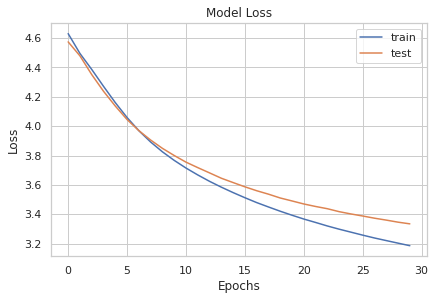

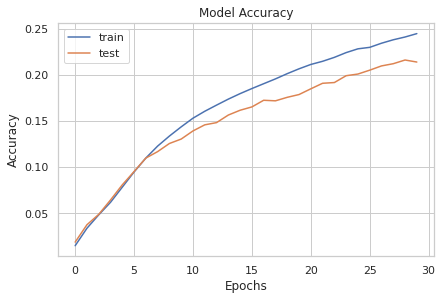

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## 4. Transfer Learning

There's a huge shortcut possible in training neural networks for recognition tasks, called transfer learning. The idea is to start with a fully trained image recognition neural network, off the shelf with  trained weights. We can repurpose the trained network for your particular recognition task, making use of the days of training that were needed to find those weights. What was learned by the neural net in it's early layers are useful features in recognizing various things in images. Keras even has pretrained models built in for this purpose. 

#### Keras Pretrained Models
        Xception
        VGG16
        VGG19
        ResNet, ResNetV2, ResNeXt
        InceptionV3
        InceptionResNetV2
        MobileNet
        MobileNetV2
        DenseNet
        NASNet

Usually one uses the layers of the pretrained model up to some point, and then creates some fully connected layers to learn the desired recognition task. The earlier layers are "frozen", and only the later layers need to be trained. We'll use VGG16, which was trained to recognize 1000 objects in ImageNet.

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

Creating this pretrained network is a one line command. Notice we specified that the "top" should not be included. We aren't classifying 1000 different categories like ImageNet, so we don't include that layer. We'll add our own layer more suited to the task at hand.

In [ ]:
# Import the VGG16 trained neural network model, minus it's last (top) neuron layer.
base_model = VGG16(weights = 'imagenet', 
                   include_top = False, 
                   input_shape = (32, 32, 3), 
                   pooling = None)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Now we'll add a flatten layer, a trainable dense layer, and a final softmax layer. This illustrates another way to create networks besides the sequential method we used for our example model.  This is the Keras functional approach to building networks. It's more flexible and more powerful than the sequential method. For example, it allows you to implement transfer learning.

In [ ]:
# Now add layers to our pre-trained base model and add classification layers on top of it
x = base_model.output
x = Flatten()(x)
x = Dense(200, activation = 'relu')(x)
predic = Dense(100, activation = 'softmax')(x) 

# And now put this all together to create our new model.
model = Model(inputs = base_model.input, outputs = predic) 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
# Compile the model.
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adagrad(lr = 0.001),
              metrics = ['acc'])

In [ ]:
# Let's also reduce the number of training epochs.
epochs = 20
batchsize = 200

In [ ]:
# Train the model
history = model.fit(X, y, batch_size = batchsize, epochs = epochs, verbose=1, validation_split=0.1)

Epoch 1/20
225/225 [==============================] - 21s 80ms/step - loss: 4.3860 - acc: 0.0472 - val_loss: 3.9232 - val_acc: 0.1074
Epoch 2/20
225/225 [==============================] - 18s 79ms/step - loss: 3.4536 - acc: 0.1935 - val_loss: 3.0869 - val_acc: 0.2516
Epoch 3/20
225/225 [==============================] - 18s 79ms/step - loss: 2.8549 - acc: 0.2955 - val_loss: 2.7497 - val_acc: 0.3206
Epoch 4/20
225/225 [==============================] - 18s 80ms/step - loss: 2.5060 - acc: 0.3656 - val_loss: 2.4696 - val_acc: 0.3674
Epoch 5/20
225/225 [==============================] - 19s 84ms/step - loss: 2.2739 - acc: 0.4090 - val_loss: 2.2859 - val_acc: 0.4120
Epoch 6/20
225/225 [==============================] - 19s 84ms/step - loss: 2.1160 - acc: 0.4418 - val_loss: 2.1791 - val_acc: 0.4332
Epoch 7/20
225/225 [==============================] - 18s 81ms/step - loss: 1.9688 - acc: 0.4738 - val_loss: 2.0885 - val_acc: 0.4556
Epoch 8/20
225/225 [==============================] - 19s 84ms

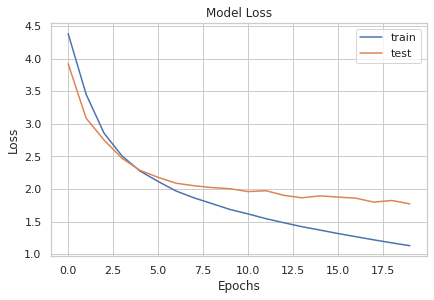

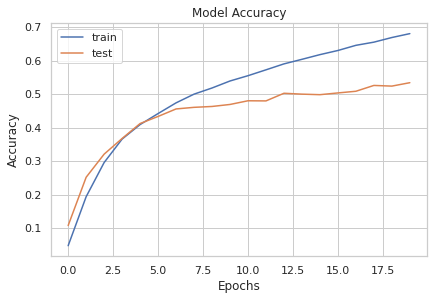

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## 5. Visualizing kernels

Neural network models are generally referred to as being opaque. This means that they are poor at explaining the reason why a specific decision or prediction was made.

Convolutional neural networks are designed to work with image data, and their structure and function suggest that should be less inscrutable than other types of neural networks.

After loading the VGG model, we can define a new model that outputs a feature map from the first convolutional layer as follows.

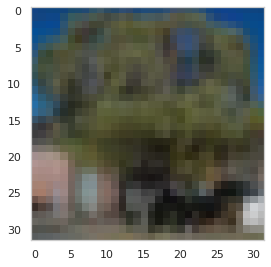

1/1 [==============================] - 0s 354ms/step


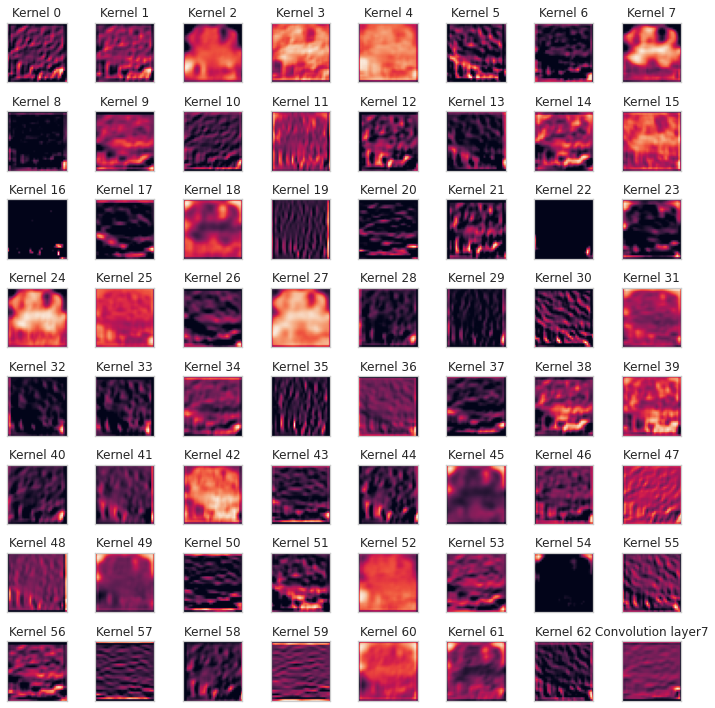

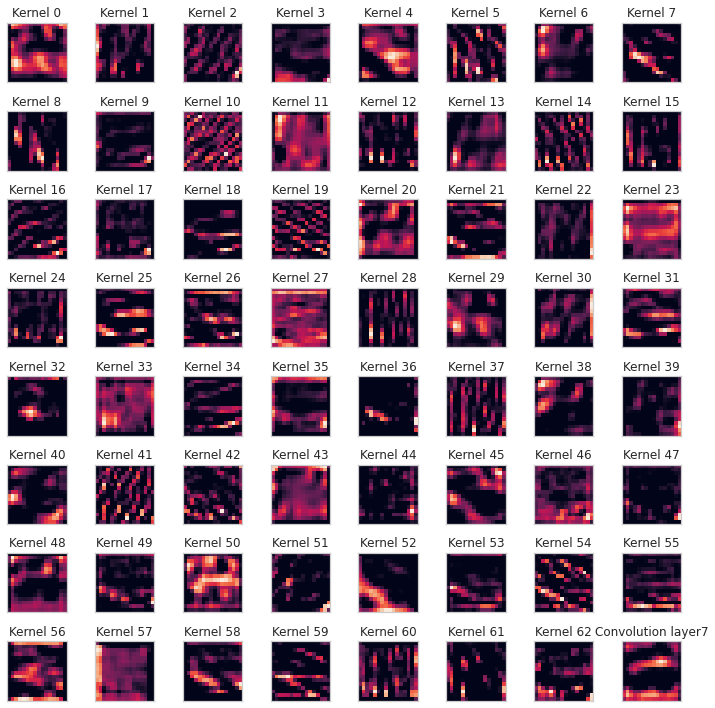

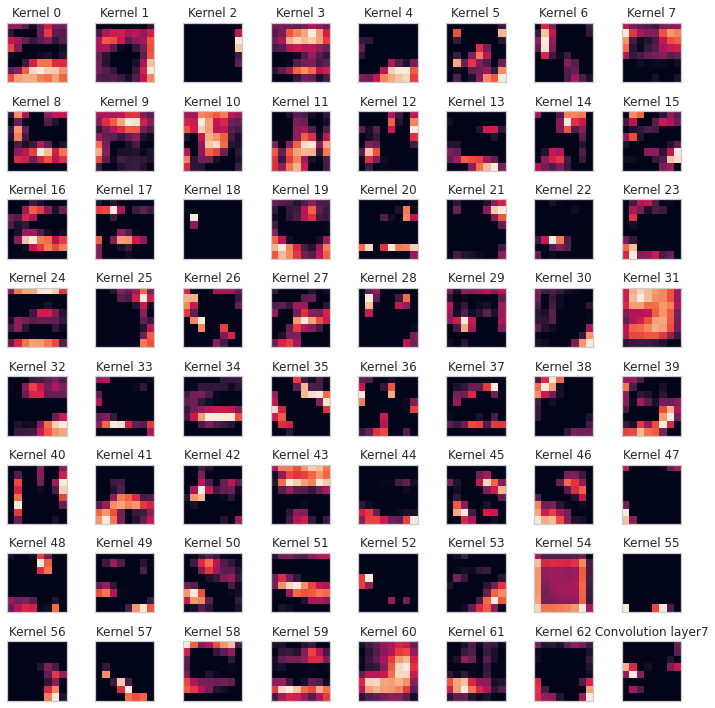

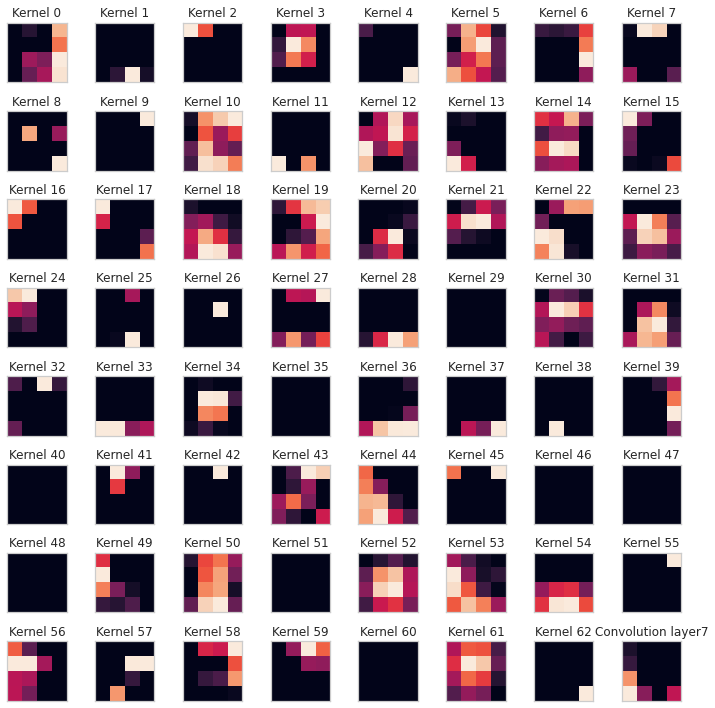

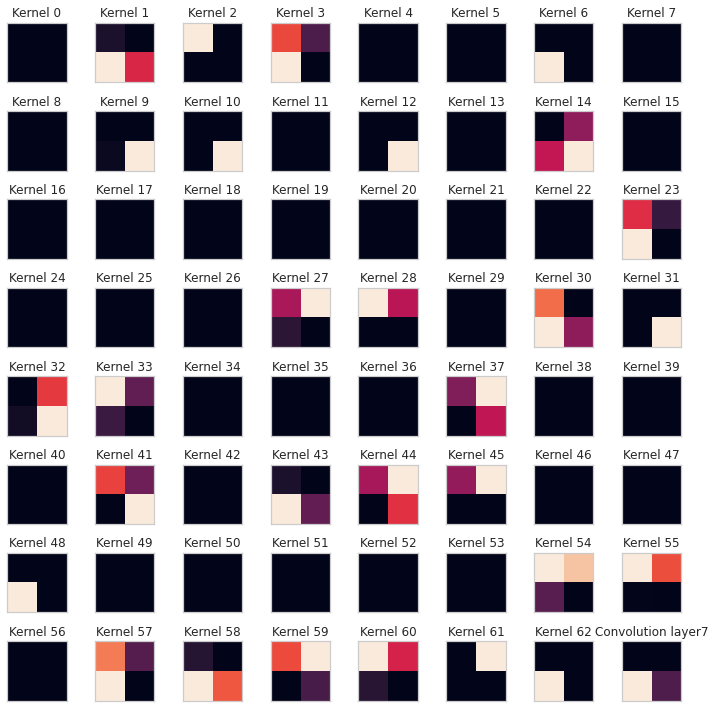

In [ ]:
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)

img = X[rn.randint(0, len(y))]
plt.imshow(img, cmap='gray')
plt.grid(None)
plt.show()

img = np.expand_dims(img, axis=0)
feature_maps = model.predict(img)

# plot all 64 maps

for i, fmaps in enumerate(feature_maps):
  fig, ax = plt.subplots(8, 8)
  fig.set_size_inches(10, 10)
  for i in range(8):
    for j in range(8):
        ax[i, j].imshow(fmaps[0, :, :, i * 8 + j])
        ax[i, j].set_title('Kernel ' + str(i * 8 + j))
        # Hide grid lines
        ax[i, j].grid(False)
        # Hide axes ticks
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
  plt.tight_layout()
  plt.title('Convolution layer' + str(i))
  # show the figure
  plt.show()

In [ ]:
### YOUR CODE HERE ###